In [1]:
!pip install git+https://github.com/UN-GCPDS/python-gcpds.utils.git > /dev/null

  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-mha7kvre


In [2]:
!pip install mne==0.19 > /dev/null

In [ ]:
import sys
sys.path.insert(0,'/kaggle/input/mi-eeg-classmeth/')

In [5]:
from gcpds.utils import loaddb
import sys
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedShuffleSplit,LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, pairwise_distances
from mne.viz import plot_topomap
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne.
import os
import time
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pickle

The subject 1 has 5 runs
(200, 64, 1792)
(200,)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
sbj1acc68.25
The subject 2 has 5 runs
(200, 64, 1792)
(200,)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
sbj2acc50.0
The subject 3 has 5 runs
(200, 64, 1792)
(200,)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
sbj3acc97.0
The subject 4 has 5 runs
(200, 64, 1792)
(200,)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
sbj4acc85.5
The subject 5 has 5 runs
(199, 64, 1792)
(199,)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
sbj5acc81.25


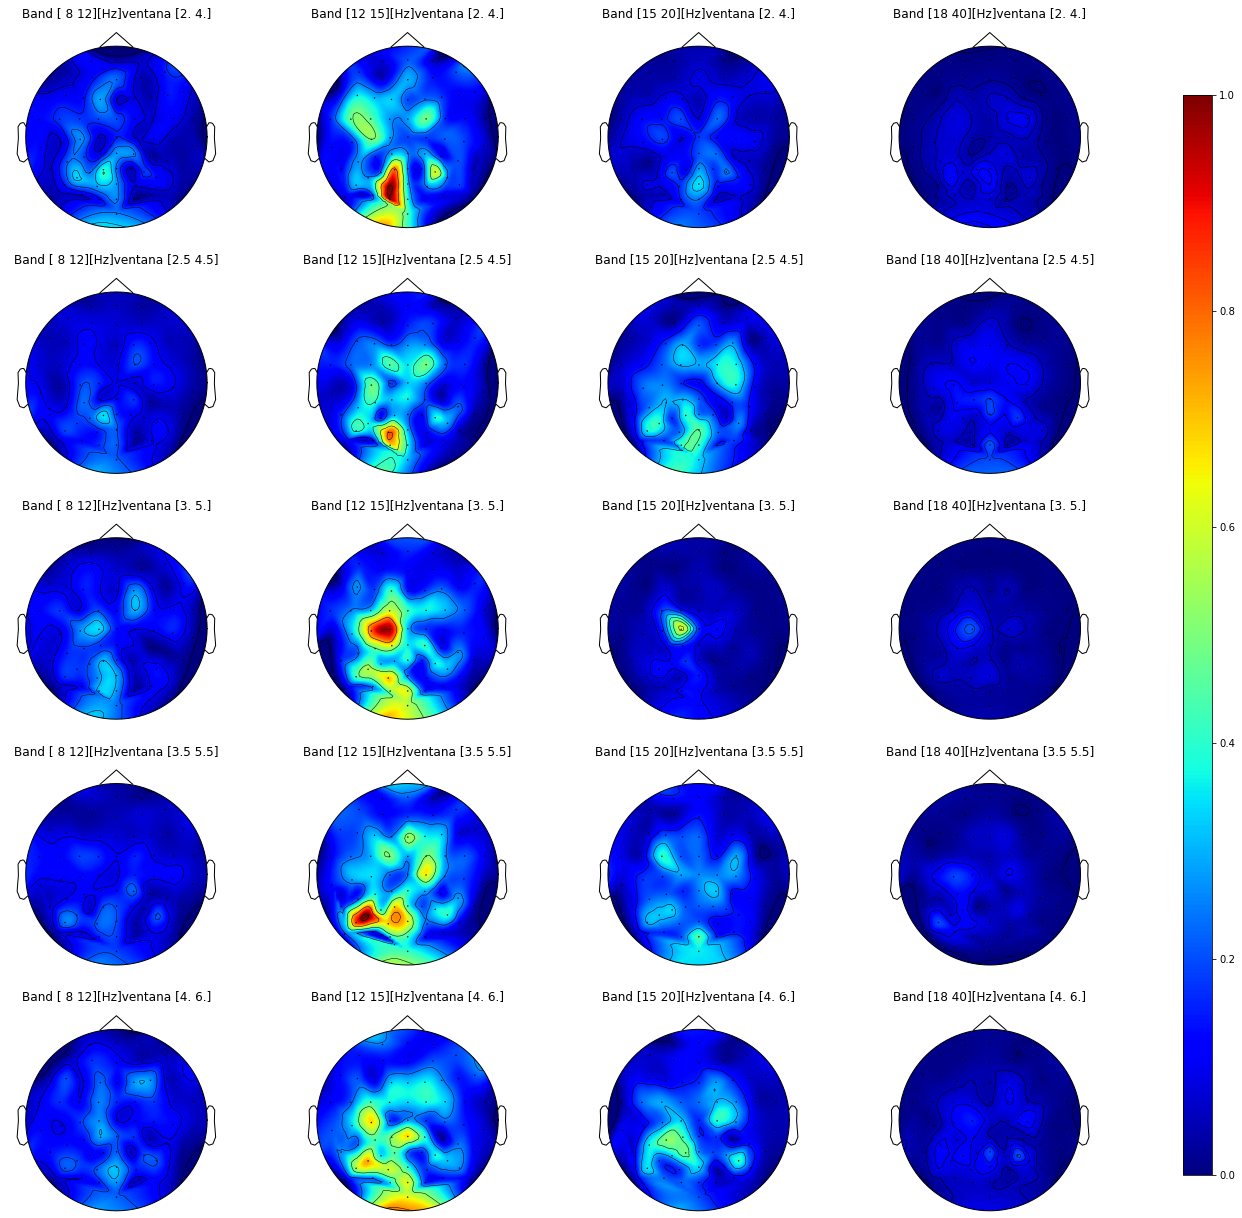

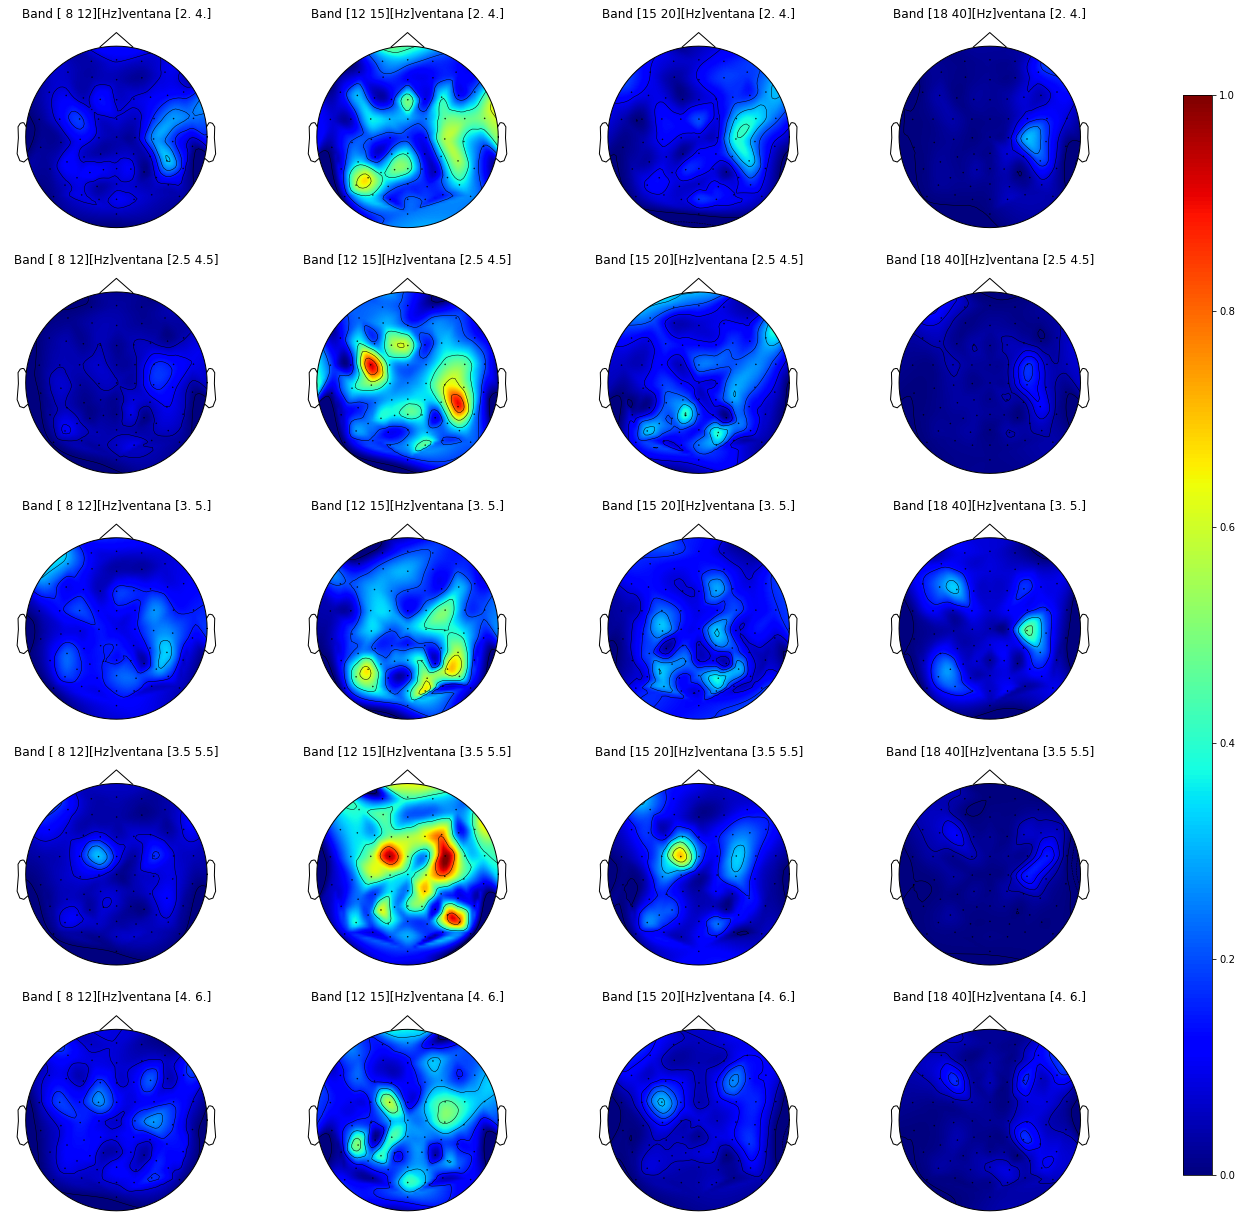

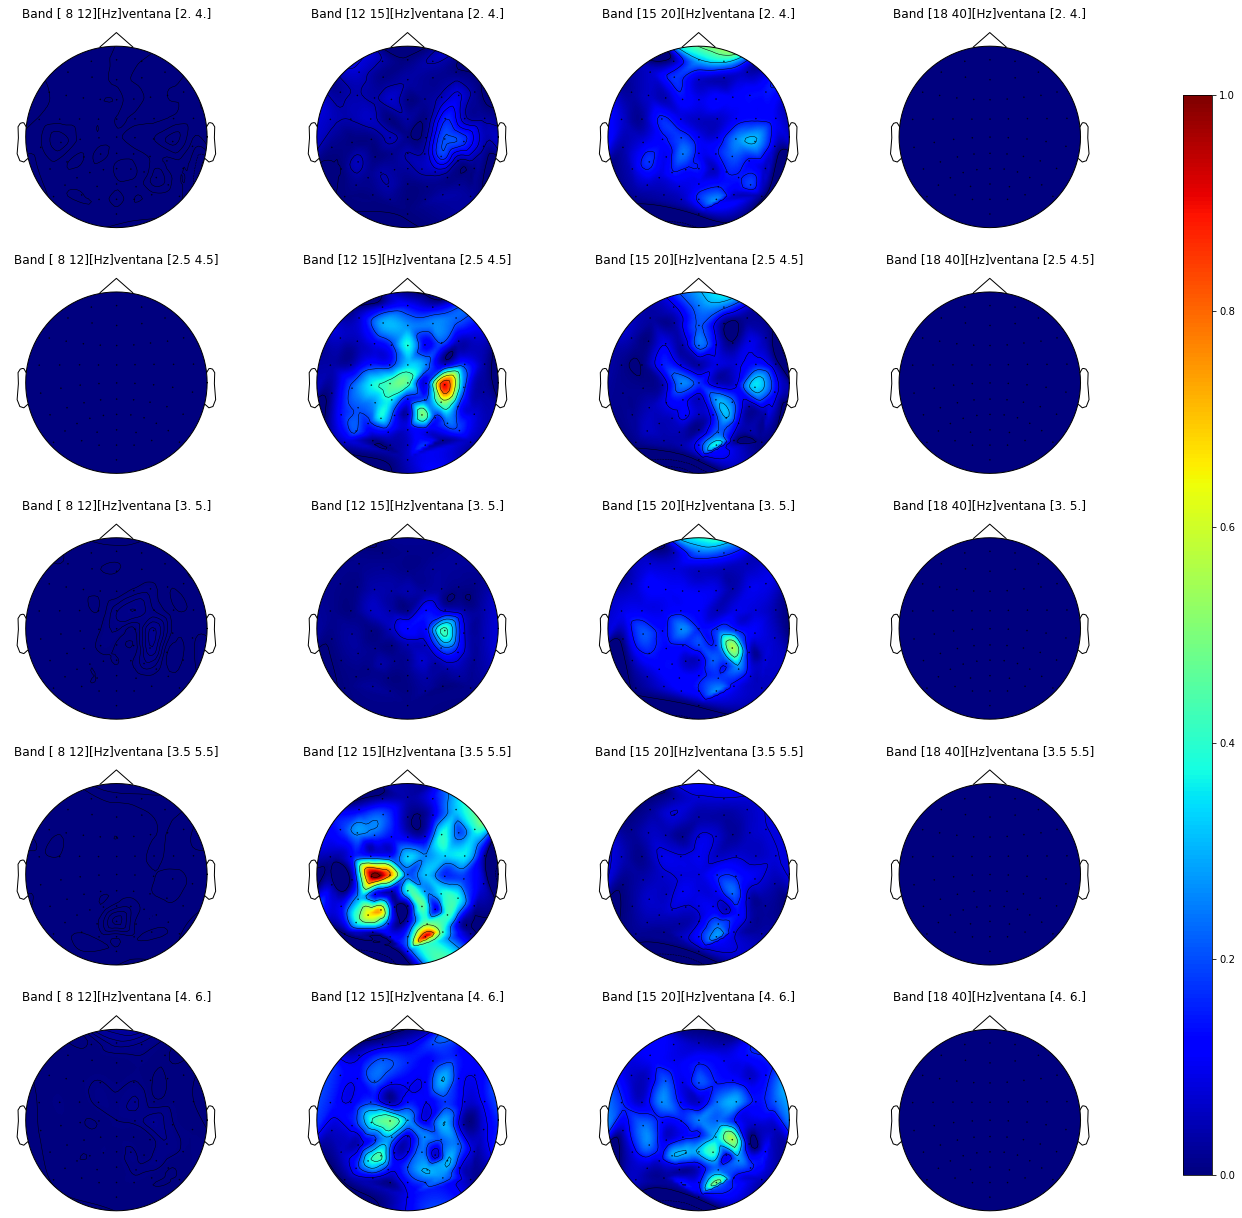

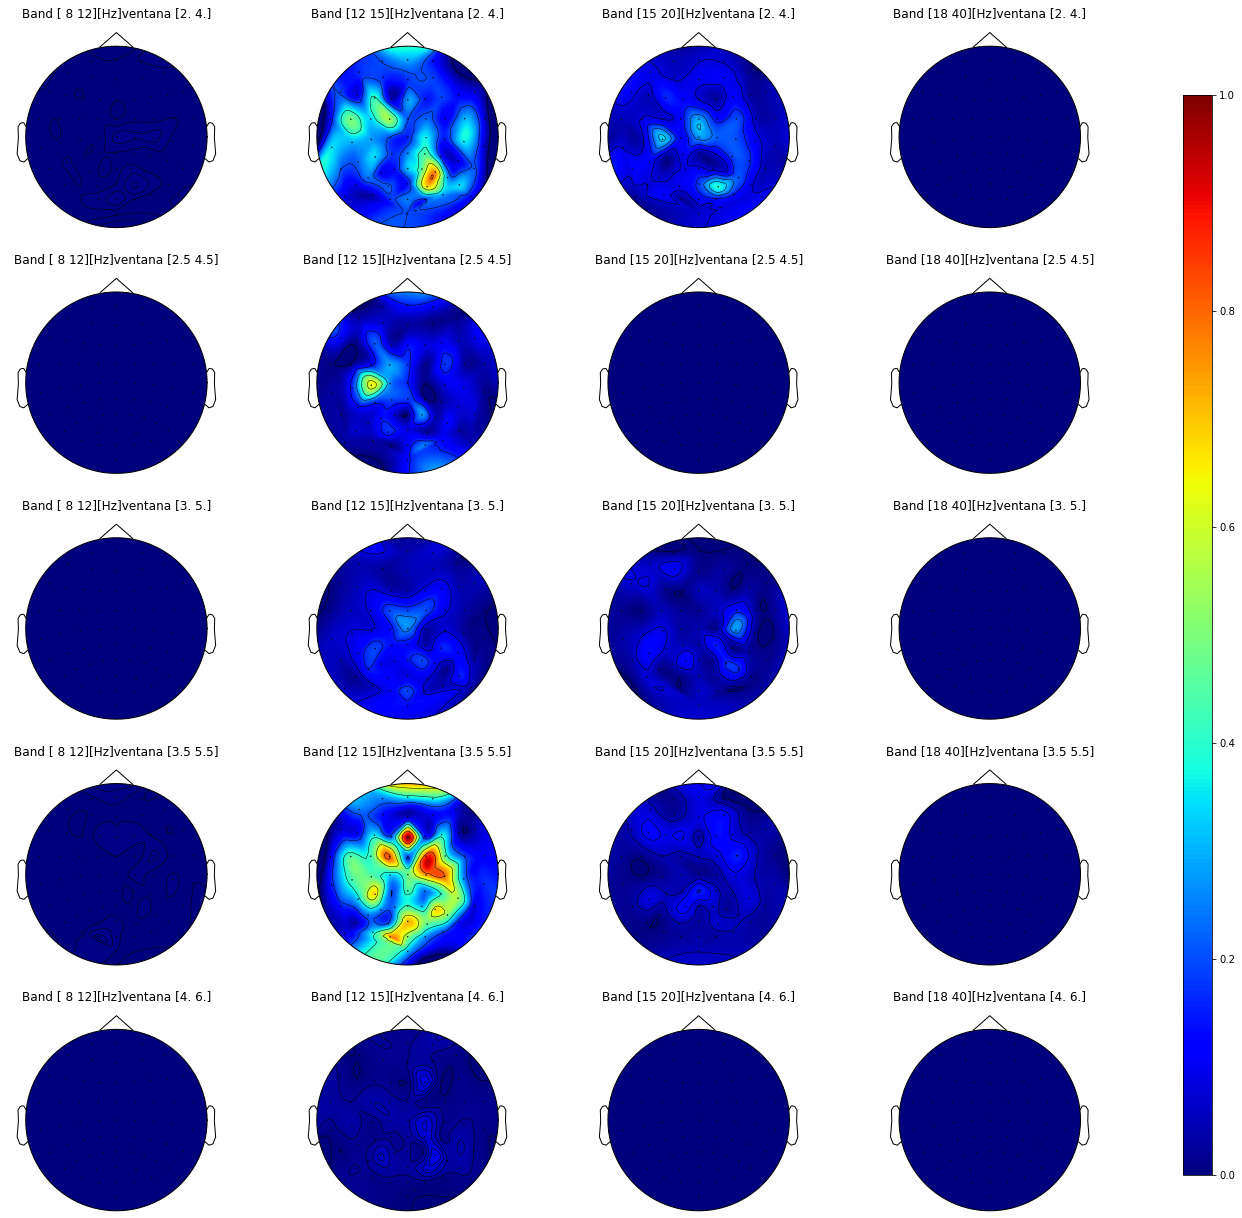

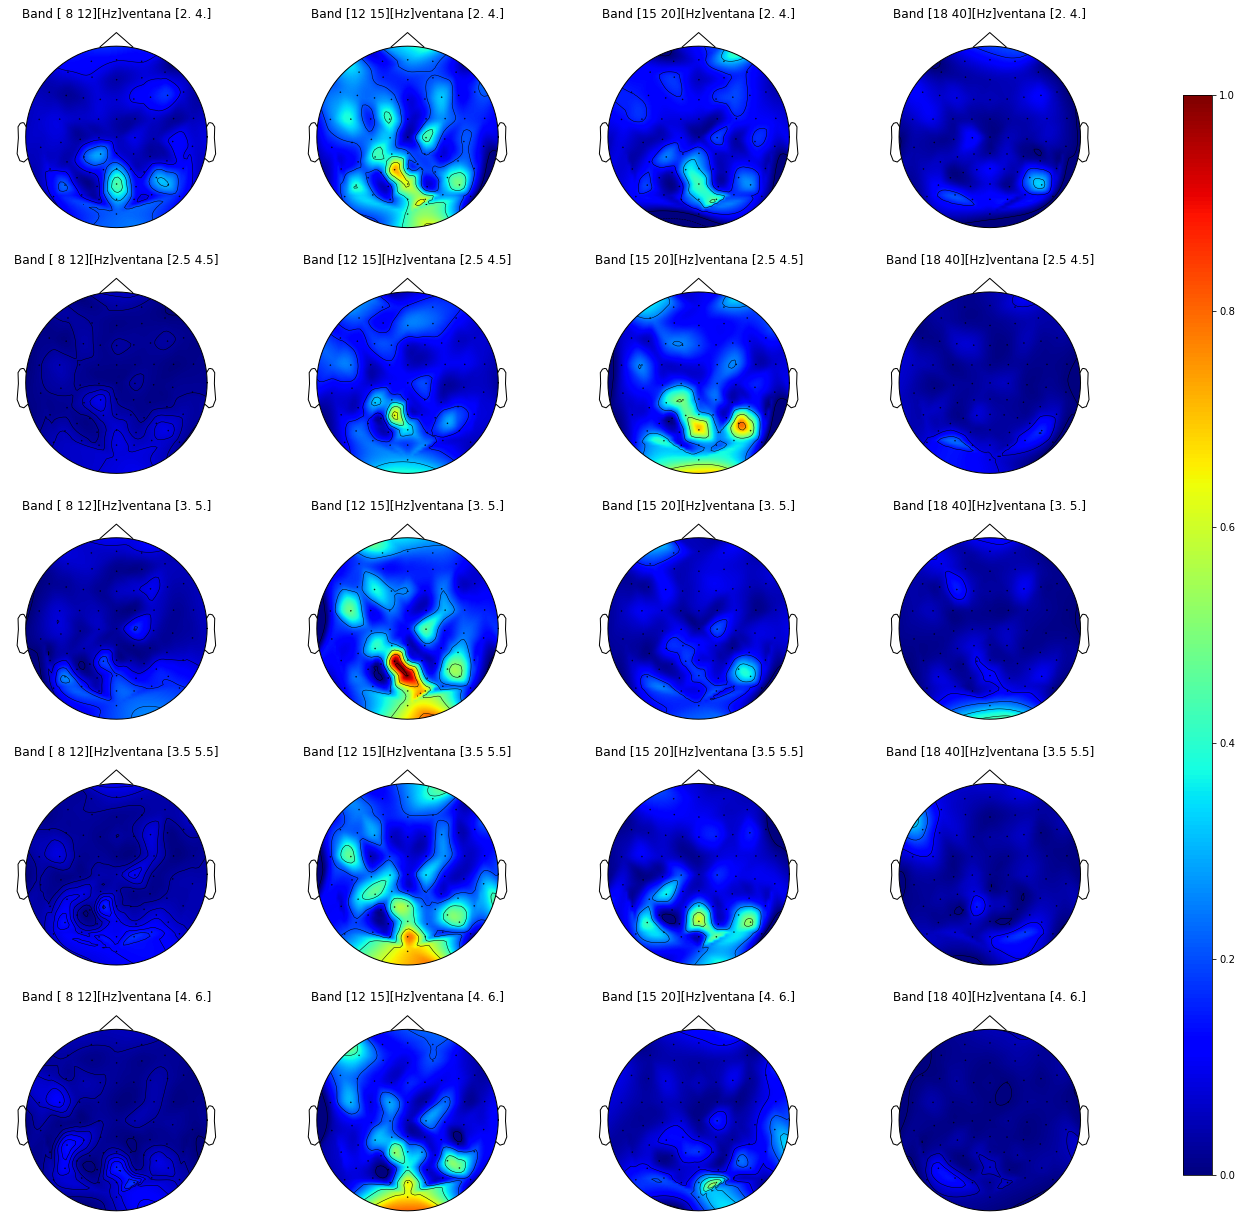

In [6]:
f_frec =  np.array([[8,12],[12,15],[15,20],[18,40]])
#vtw= np.array([[0,2],[1,3],[2,4],[3,5],[4,6],[5,7]])
tau =  2
overlap=1-0.75
ti = 2
tf = 6
tti = np.arange(ti,tf-tau+(tau*overlap),tau*overlap)
ttf = np.arange(ti+tau,tf+tau*overlap,tau*overlap)
vtw = np.array([tti,ttf]).T
#vtw= np.array([[0,2]])
#f_frec = np.array([[2.5,4.5]])
subjects = np.arange(52)+1
subjects=np.delete(subjects,[28,33])
for sbj in subjects[:5]:#subjects:
    db = loaddb.GIGA('../input/giga-science-gcpds/GIGA_MI_ME/')
    db.load_subject(sbj)
    print(f'The subject {sbj} has {db.runs} runs')
    Xraw, y = db.get_data(reject_bad_trials=True,classes=['left hand mi', 'right hand mi'])
    #run[i], class_[i] = db.get_run(i,classes=['left hand', 'right hand'])
    Xraw = np.asarray(Xraw)
    Xraw=Xraw[:,:,::2]
    print(Xraw.shape)
    y = np.asarray(y,dtype=np.float64).ravel()
    y[y==0]=-1
    print(y.shape)
    fs =db.metadata['sampling_rate']/2
    #fs =db.metadata['sampling_rate']
    channels_names = db.metadata['channel_names']
    montage = mne.channels.read_montage(db.metadata['montage'], channels_names)
    info = mne.create_info(channels_names, sfreq=fs, ch_types="eeg",
                            montage=montage) 
    #opt = tf.keras.optimizers.RMSprop(learning_rate=1e-1)
    steps=[('CSP_window_time',Window_band_CSP_eppoch(fs=fs,vtw=vtw,f_frec=f_frec)),
            ('flat',flatt()),
            ('stand',StandardScaler()),
            ('proy',elastic_net_feats()),
            ('cla', LDA())]    
    method = Pipeline(steps,memory='/kaggle/tmp/datospipeline')
    parameters ={'CSP_window_time__ncomp':[6],
                 'proy__alpha':[0, 0.001, 0.1, 1], #0, 0.001, 0.1, 1
                'proy__l1_ratio':[0, 0.5, 1]} #[0, 0.5, 1]
    scores = {'acc': 'accuracy','kappa': make_scorer(cohen_kappa_score,greater_is_better=True)}    
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    grid_search = GridSearchCV(method, parameters,cv=cv,verbose=10,
                               scoring=scores,refit='acc',n_jobs=-1)
    #grid_search = GridSearchCV(method, parameters,cv=cv,verbose=10,
     #                          scoring=kappa_,n_jobs=-1)
    #try:
    grid_search.fit(Xraw,y)
    results = grid_search.cv_results_
    filters = grid_search.best_estimator_['CSP_window_time'].filters
    ncomp = grid_search.best_estimator_['CSP_window_time'].ncomp
    #%% topoplots
    elastic=grid_search.best_estimator_['proy']
    rho = abs(elastic.elatic.coef_)
    rho = rho.reshape((len(vtw),ncomp,-1))
    rhocka = np.zeros((len(vtw),len(f_frec),len(channels_names)))
    if np.logical_and(len(f_frec)>1,len(vtw)>1):
        for i in range(len(vtw)):
          for j in range(len(f_frec)):
            rhocka[i,j,:] =  np.sum(np.diag(np.abs(rho[i,:,j])).dot(np.abs(filters[i][:,:,j])),0)
        rhocka -= np.min(rhocka)
        rhocka /= np.max(rhocka)
        f,ax = plt.subplots(len(vtw),len(f_frec),figsize=(20,20))
        cmap='jet'
        for ii in range(len(vtw)):
          for jj in range(len(f_frec)):
              plot_topomap(rhocka[ii,jj,:], info, axes=ax[ii,jj], show=False,cmap=cmap,vmin=np.min(rhocka),vmax=np.max(rhocka))
              ax[ii,jj].set_title('Band '+str(f_frec[jj])+'[Hz]'+'ventana '+str(vtw[ii]))
        cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        plt.colorbar(sm,cax=cax)
    elif np.logical_and(len(f_frec)>1,len(vtw)==1):
        for j in range(len(f_frec)):
          rhocka[0,j,:] =  np.sum(np.diag(np.abs(rho[0,:,j])).dot(np.abs(filters[0][:,:,j])),0)
        rhocka=rhocka.squeeze()
        rhocka -= np.min(rhocka)
        rhocka /= np.max(rhocka)
        f,ax = plt.subplots(len(f_frec),1,figsize=(20,20))
        cmap='jet'
        for jj in range(len(f_frec)):
            plot_topomap(rhocka[jj,:], info, axes=ax[jj], show=False,cmap=cmap,vmin=np.min(rhocka),vmax=np.max(rhocka))
            ax[jj].set_title('Band '+str(f_frec[jj])+'[Hz]'+'ventana '+str(vtw))
        cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        plt.colorbar(sm,cax=cax)  
    else:
        for i in range(len(vtw)):
            rhocka[i,:] =  np.sum(np.diag(np.abs(rho[i,:,0])).dot(np.abs(filters[i][:,:,0])),0)
        rhocka -= np.min(rhocka)
        rhocka /= np.max(rhocka)
        f,ax = plt.subplots(len(vtw),1,figsize=(20,20))
        cmap='jet'
        for ii in range(len(vtw)):
              plot_topomap(rhocka[ii,0,:], info, axes=ax[ii], show=False,cmap=cmap,vmin=np.min(rhocka),vmax=np.max(rhocka))
              ax[ii].set_title(str(f_frec[0])+'Hz'+str(vtw[ii])+'seg')
        cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        plt.colorbar(sm,cax=cax)   
    plt.savefig('csp_elastic_sbj'+str(sbj)+'acc'+str(np.round(grid_search.best_score_,2))+'.eps',format='eps')#,dpi=300)
    #plt.savefig('sbj'+str(sbj)+'kappa'+str(np.round(grid_search.best_score_,2))+'.png',format='png')#,dpi=300)
    savedata ={
        'steps':steps,
        'f_frec':f_frec,
        'vtw':vtw,
        'best_param':grid_search.best_params_,
        'rhocka':rhocka,        
        'cv_results':results
    }
    #dump(savedata,'sujeto_'+str(sbj)+'_cka_featuresCSP_BCI2a_acc.joblib')
    dump(savedata,'tau_'+str(tau)+'_sujeto_'+str(sbj)+'_elastic_featuresCSP_GIGA_MI_acc.joblib')
    print('sbj'+str(sbj)+'acc'+str(np.round(grid_search.best_score_*100,4)))

In [7]:
!zip Results-joblib.zip ./*.joblib
!zip Results-images.zip ./*.eps

  adding: tau_2_sujeto_1_elastic_featuresCSP_GIGA_MI_acc.joblib (deflated 26%)
  adding: tau_2_sujeto_2_elastic_featuresCSP_GIGA_MI_acc.joblib (deflated 26%)
  adding: tau_2_sujeto_3_elastic_featuresCSP_GIGA_MI_acc.joblib (deflated 44%)
  adding: tau_2_sujeto_4_elastic_featuresCSP_GIGA_MI_acc.joblib (deflated 55%)
  adding: tau_2_sujeto_5_elastic_featuresCSP_GIGA_MI_acc.joblib (deflated 27%)
  adding: csp_elastic_sbj1acc0.68.eps (deflated 88%)
  adding: csp_elastic_sbj2acc0.5.eps (deflated 88%)
  adding: csp_elastic_sbj3acc0.97.eps (deflated 92%)
  adding: csp_elastic_sbj4acc0.86.eps (deflated 93%)
  adding: csp_elastic_sbj5acc0.81.eps (deflated 88%)
